In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from statsmodels.stats.libqsturng import qsturng
import Orange
import itertools

In [3]:
path = '../../output/20160307-cherry-dc-long'

In [4]:
#periods = ['(1991 2010)', '(1971 2010)', '(1951 2010)']
#periods = [20, 40, 60]
periods = [10, 20, 30, 40, 50, 60]

In [5]:
def read_suite(cultivar, years, path=path):
    template = '{path}/suite/results/crossvalidation_cherry_dc_{cultivar}_724050_DC_{years}_Peak Bloom_ie.csv'
    filename = template.format(**{'path': path, 'cultivar': cultivar, 'years': str(years).replace(',', '')})
    df = pd.read_csv(filename)
    return df.set_index(['Unnamed: 0']).mean()

Read cross-validation output for a given metric.

In [6]:
def read(how, period, path=path):
    df = pd.read_csv('{}/collection/results/crossvalidation_{}_{}_raw_ie.csv'.format(path, period, how))
    df['period'] = period
    return df

We'll use 7 different metrics for cross-validation.

In [7]:
#metrics = ['rmse', 'me', 'mae', 'xe', 'ef', 'ef1', 'd', 'd1', 'dr', 'm', 'r']
metrics = ['ef', 'ef1', 'd', 'd1', 'dr', 'm', 'r']

Create a dataframe from the output with given columns.

In [8]:
def load(columns, period, path=path, metrics=metrics):
    return pd.concat([read(m, period, path) for m in metrics]).set_index(['how', 'title', 'period', 'seq'])[columns]

In [9]:
def load2(columns, period, path=path, metrics=metrics):
    df = pd.concat([read(m, period, path) for m in metrics])
    df['group'] = (df.seq / 5).astype(int)
    return df.set_index(['how', 'title', 'period', 'group'])[columns]

Default functions (`load` and `rank`) treat cross-validation samples indepenently, whereas variant functions (`load2` and `rank2`) treat them as replicates.

We'll test 3 scenarios:
1. Between individual models
2. Individual models vs. an ensemble (EN)
3. Between ensemble models.

In [10]:
individuals = ['GD', 'CF', 'BF', 'DTS', 'SF', 'TP', 'SM', 'PM', 'AM'] + ['M']
individuals_with_ensemble = individuals + ['EN']
#individuals_with_ensemble = individuals + ['EN', 'EN.rf', 'EN.rf2']
ensembles = ['EN', 'EN.rmse', 'EN.d', 'EN.d1', 'EN.dr', 'EN.ef', 'EN.ef1', 'EN.m', 'EN.r', 'EN.rf', 'EN.rf2']
individuals_with_ensemble_all = individuals + ensembles

Here is a part of the dataframe for the second scenario.

In [11]:
load(individuals_with_ensemble, periods[0]).head()

GD         CF         BF        DTS  \
how title     period seq                                               
EF  cherry_dc 10     0    -5.284722  -4.586806  -7.125000 -18.934028   
                     1   -14.771701  -0.513889 -14.138889 -12.203125   
                     2    -0.211559   0.991453  -0.322095  -0.027387   
                     3    -5.417535        NaN  -5.983507  -2.490451   
                     4   -36.725694 -48.340278 -15.701389 -20.392361   

                                 SF          TP         SM         PM  \
how title     period seq                                                
EF  cherry_dc 10     0   -16.934028  -16.000000 -38.309028 -13.569444   
                     1   -13.490451  -35.250000 -11.514757  -6.254340   
                     2    -0.100016   -0.591716   0.962504   0.797974   
                     3   -10.628472 -140.250000        NaN        NaN   
                     4   -40.475694  -28.000000 -45.590278 -45.944444   

                                  AM          M        EN  
how title     period seq                                   
EF  cherry_dc 10     0   -860.138889 -30.250000 -0.237878  
                     1    -32.493924  -0.765625 -2.182430  
                     2      0.985002  -0.534024  0.967510  
                     3    -13.868056  -0.765625 -0.285325  
                     4    -33.368056  -0.250000 -6.150857

In [12]:
load(ensembles, periods[0]).head()

EN   EN.rmse      EN.d     EN.d1     EN.dr  \
how title     period seq                                                     
EF  cherry_dc 10     0   -0.237878 -0.631543 -1.390388 -1.030478 -0.326520   
                     1   -2.182430 -3.311447 -3.008688 -3.033579 -2.506811   
                     2    0.967510  0.953033  0.973823  0.972943  0.926827   
                     3   -0.285325 -0.325764 -0.302882 -0.282359 -0.282685   
                     4   -6.150857 -9.391767 -8.203420 -8.478478 -7.049730   

                             EN.ef    EN.ef1      EN.m      EN.r     EN.rf  \
how title     period seq                                                     
EF  cherry_dc 10     0   -1.460790 -0.730123 -1.612022 -1.644476  0.127726   
                     1   -3.139360 -3.273876 -3.178835 -3.190639 -1.045287   
                     2    0.999556  0.997957  0.991965  0.993723 -0.221374   
                     3   -0.353982 -0.280728 -0.308615 -0.275230  0.210480   
                     4   -8.649451 -9.223156 -8.674259 -8.949831 -0.516450   

                            EN.rf2  
how title     period seq            
EF  cherry_dc 10     0    0.410826  
                     1   -1.787071  
                     2    0.971174  
                     3   -0.126279  
                     4   -5.490653

In [13]:
load2(ensembles, periods[0]).head()

EN   EN.rmse      EN.d     EN.d1     EN.dr  \
how title     period group                                                     
EF  cherry_dc 10     0     -0.237878 -0.631543 -1.390388 -1.030478 -0.326520   
                     0     -2.182430 -3.311447 -3.008688 -3.033579 -2.506811   
                     0      0.967510  0.953033  0.973823  0.972943  0.926827   
                     0     -0.285325 -0.325764 -0.302882 -0.282359 -0.282685   
                     0     -6.150857 -9.391767 -8.203420 -8.478478 -7.049730   

                               EN.ef    EN.ef1      EN.m      EN.r     EN.rf  \
how title     period group                                                     
EF  cherry_dc 10     0     -1.460790 -0.730123 -1.612022 -1.644476  0.127726   
                     0     -3.139360 -3.273876 -3.178835 -3.190639 -1.045287   
                     0      0.999556  0.997957  0.991965  0.993723 -0.221374   
                     0     -0.353982 -0.280728 -0.308615 -0.275230  0.210480   
                     0     -8.649451 -9.223156 -8.674259 -8.949831 -0.516450   

                              EN.rf2  
how title     period group            
EF  cherry_dc 10     0      0.410826  
                     0     -1.787071  
                     0      0.971174  
                     0     -0.126279  
                     0     -5.490653

Generate a rank out of the dataframe.

In [14]:
def rank(df):
    return df.rank(axis=1, ascending=False).groupby(level=[0,1,2]).mean()

In [15]:
def rank2(df):
    return df.rank(axis=1, ascending=False).groupby(level=[0,1,2,3]).mean()

Here is a part of the generated ranks for the second scenario.

In [16]:
rank(load(individuals_with_ensemble, periods[0])).head()

,,,GD,CF,BF,DTS,SF,TP,SM,PM,AM,M,EN
how,title,period,,,,,,,,,,,
D,cherry_dc,10,7.300000,4.375000,6.300000,5.700000,7.000000,6.500000,5.666667,4.555556,7.100000,7.100000,2.200000
D1,cherry_dc,10,7.300000,4.500000,6.400000,6.300000,7.200000,6.400000,5.500000,4.833333,7.300000,5.800000,2.300000
DR,cherry_dc,10,7.300000,5.375000,6.600000,5.400000,6.500000,6.550000,6.166667,5.388889,7.200000,5.350000,2.300000
EF,cherry_dc,10,7.333333,5.285714,6.555556,5.111111,6.555556,6.333333,6.125000,5.500000,7.444444,5.777778,1.888889
EF1,cherry_dc,10,7.444444,5.285714,6.666667,5.333333,6.555556,6.611111,6.187500,5.312500,7.333333,5.277778,1.888889


In [17]:
rank(load(ensembles, periods[0])).head()

,,,EN,EN.rmse,EN.d,EN.d1,EN.dr,EN.ef,EN.ef1,EN.m,EN.r,EN.rf,EN.rf2
how,title,period,,,,,,,,,,,
D,cherry_dc,10,6.100000,5.700000,6.100000,5.700000,5.900000,7.500000,5.900000,6.100000,5.400000,7.100000,4.500000
D1,cherry_dc,10,6.000000,5.100000,6.700000,6.300000,5.700000,7.000000,5.800000,5.900000,5.800000,6.700000,5.000000
DR,cherry_dc,10,6.100000,5.300000,7.000000,6.700000,5.900000,7.300000,6.100000,6.400000,6.100000,4.900000,4.200000
EF,cherry_dc,10,6.333333,5.777778,6.666667,6.111111,6.222222,7.777778,6.222222,6.444444,5.777778,5.222222,3.444444
EF1,cherry_dc,10,6.111111,5.222222,7.111111,6.777778,5.888889,7.444444,6.111111,6.444444,6.111111,4.777778,4.000000


In [18]:
rank2(load2(individuals_with_ensemble, periods[0])).head()

GD    CF   BF  DTS   SF   TP     SM     PM   AM  \
how title     period group                                                     
D   cherry_dc 10     0      6.6  2.50  5.6  5.4  8.0  7.6  7.000  5.250  7.0   
                     1      8.0  6.25  7.0  6.0  6.0  5.4  4.600  4.000  7.2   
D1  cherry_dc 10     0      6.4  3.00  5.4  7.0  8.2  7.4  6.125  4.875  7.2   
                     1      8.2  6.00  7.4  5.6  6.2  5.4  5.000  4.800  7.4   
DR  cherry_dc 10     0      6.0  4.00  5.8  5.4  7.0  8.3  7.125  5.875  7.2   

                              M   EN  
how title     period group            
D   cherry_dc 10     0      6.2  1.8  
                     1      8.0  2.6  
D1  cherry_dc 10     0      5.2  2.0  
                     1      6.4  2.6  
DR  cherry_dc 10     0      4.7  2.0

Now we have 3 rank dataframes for each scenario.

Average across all datasets, giving one sample per model.

In [19]:
rii = {p: rank(load(individuals, p)) for p in periods}
rie = {p: rank(load(individuals_with_ensemble, p)) for p in periods}
ree = {p: rank(load(ensembles, p)) for p in periods}
rall = {p: rank(load(individuals_with_ensemble_all, p)) for p in periods}

In [20]:
#rii.to_csv('rii.csv')
#rie.to_csv('rie.csv')
#ree.to_csv('ree.csv')
#rall.to_csv('rall.csv)

Make an individual sample by different species, but merge replicates from crossvalidation.

In [21]:
rii2 = {p: rank2(load2(individuals, p)) for p in periods}
rie2 = {p: rank2(load2(individuals_with_ensemble, p)) for p in periods}
ree2 = {p: rank2(load2(ensembles, p)) for p in periods}
rall2 = {p: rank2(load2(individuals_with_ensemble_all, p)) for p in periods}

Count crossvalidation as an individual sample.

In [22]:
rii3 = {p: rank2(load(individuals, p)) for p in periods}
rie3 = {p: rank2(load(individuals_with_ensemble, p)) for p in periods}
ree3 = {p: rank2(load(ensembles, p)) for p in periods}
rall3 = {p: rank2(load(individuals_with_ensemble_all, p)) for p in periods}

Conduct Friedman test on the rank dataframe.

In [23]:
def friedman(rdf, how):
    return st.friedmanchisquare(*rdf.loc[how].as_matrix().T)

In [24]:
def friedmans(rdf):
    return pd.DataFrame({h: friedman(rdf, h) for h in hows}, index=['statistic', 'pvalue'])

Friedman test over individual models for Willmot's refined index of agreement (Dr) turns out to be non-significant (p=0.08).

In [25]:
friedman(rii[20], 'DR')

FriedmanchisquareResult(statistic=9.0, pvalue=0.43727418891386705)

In [26]:
friedman(rii2[20], 'DR')

FriedmanchisquareResult(statistic=12.156923076923073, pvalue=0.20460663221710376)

On the other hand, Friedman test over individuals with an ensemble model turns out to be significant (p=0.01) that there is a difference between models, in this case, due to the just added ensemble model.

In [27]:
friedman(rie[20], 'DR')

FriedmanchisquareResult(statistic=10.0, pvalue=0.44049328506521224)

In [28]:
friedman(rie2[20], 'DR')

FriedmanchisquareResult(statistic=14.555808656036454, pvalue=0.14911488147449006)

Meanwhile, Friedman test over different ensemble models turns out to be highly non-significant (p=0.65), so we can't tell there is a difference in performance between them.

In [29]:
friedman(ree[20], 'DR')

FriedmanchisquareResult(statistic=10.0, pvalue=0.44049328506521224)

In [30]:
friedman(ree2[20], 'DR')

FriedmanchisquareResult(statistic=13.78995433789955, pvalue=0.1827898298283209)

Here is a summary over all metrics.

Friedman tests over individual models. They are all non-significant at p=0.05.

In [31]:
hows = rii[20].index.levels[0]
hows

Index(['D', 'D1', 'DR', 'EF', 'EF1', 'M', 'R'], dtype='object', name='how')

In [32]:
friedmans(rii[20])

,D,D1,DR,EF,EF1,M,R
statistic,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
pvalue,0.437274,0.437274,0.437274,0.437274,0.437274,0.437274,0.437274


In [33]:
friedmans(rii2[20])

,D,D1,DR,EF,EF1,M,R
statistic,10.932515,10.238532,12.156923,11.416667,12.156923,10.706422,9.664615
pvalue,0.280363,0.331522,0.204607,0.248226,0.204607,0.296370,0.378312


In [34]:
friedmans(rank2(load2(['GD', 'CF', 'BF'], periods[0])))

,D,D1,DR,EF,EF1,M,R
statistic,3.714286,3.714286,1.000000,1.000000,1.000000,1.000000,3.714286
pvalue,0.156118,0.156118,0.606531,0.606531,0.606531,0.606531,0.156118


Friedman tests over individual models with an ensemble model. They are all significant at p=0.01.

In [35]:
friedmans(rie[20])

,D,D1,DR,EF,EF1,M,R
statistic,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
pvalue,0.440493,0.440493,0.440493,0.440493,0.440493,0.440493,0.440493


In [36]:
friedmans(rie2[20])

,D,D1,DR,EF,EF1,M,R
statistic,13.638444,13.348624,14.555809,14.233410,14.555809,13.577982,12.465753
pvalue,0.190131,0.204828,0.149115,0.162609,0.149115,0.193126,0.255093


Friedman test over ensemble models. Most of them are highly non-significant, but there are a couple that indicates significance.

In [37]:
friedmans(ree[20])

,D,D1,DR,EF,EF1,M,R
statistic,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
pvalue,0.440493,0.440493,0.440493,0.440493,0.440493,0.440493,0.440493


In [38]:
friedmans(ree2[20])

,D,D1,DR,EF,EF1,M,R
statistic,8.672769,15.160550,13.789954,15.707763,13.789954,8.922018,13.940092
pvalue,0.563415,0.126317,0.182790,0.108309,0.182790,0.539520,0.175742


Look at the difference between averaged ranks.

In [39]:
rii2[20].groupby(level='how').mean()

,GD,CF,BF,DTS,SF,TP,SM,PM,AM,M
how,,,,,,,,,,
D,3.9,5.40,4.60,3.4,5.30,6.10,4.7,4.6,8.0,9.00
D1,4.3,4.10,4.70,4.1,5.60,6.10,4.7,5.0,7.5,8.90
DR,4.1,4.65,4.65,3.4,5.65,6.45,4.9,5.0,9.0,7.20
EF,3.7,5.40,4.70,3.6,5.30,6.30,4.6,4.7,8.7,8.00
EF1,4.1,4.65,4.65,3.4,5.65,6.45,4.9,5.0,9.0,7.20
M,4.0,5.90,4.80,3.2,5.10,6.05,4.6,4.6,7.3,9.45
R,4.7,4.70,4.60,3.5,5.20,5.65,5.0,5.5,6.4,9.75


In [40]:
rii2[20].mean(axis=0).sort_values()

DTS    3.514286
GD     4.114286
BF     4.671429
SM     4.771429
PM     4.914286
CF     4.971429
SF     5.400000
TP     6.157143
AM     7.985714
M      8.500000
dtype: float64

Calculate critial difference for Nemenyi test.

In [41]:
def critical_value(p, k):
    return qsturng(1-p, k, np.inf) / np.sqrt(2)

def critical_difference(p, k, n):
    return critical_value(p, k) * np.sqrt((k*(k+1)) / (6*n))

In [42]:
critical_difference(0.05, 4, 5)

2.0975924614902377

In [43]:
critical_difference(0.05, 5, 5)

2.7277508838690383

In [44]:
critical_difference(0.05, 8, 5)

4.6953889282071719

In [45]:
critical_difference(0.05, 4, 137)

0.40072444135775453

In [46]:
critical_difference(0.10, 4, 137)

0.35739849198748025

In [47]:
critical_difference(0.05, 5, 137)

0.52111001978189975

In [48]:
critical_difference(0.05, 8, 137)

0.89700794589834176

In [49]:
def plot_ranks(rdf, how, p=0.05, mark=None, lowv=None, highv=None, **kwargs):
    df = rdf.loc[how]
    s = df.mean(axis=0)
    cd = critical_difference(p, len(s), len(df))
    Orange.evaluation.graph_ranks(s, s.index, cd, mark, lowv=lowv, highv=highv, **kwargs)

In [50]:
#plot_ranks(rii2, 'DR')

In [51]:
def plot_ranks_all(rdf, p=0.05, mark=None, lowv=None, highv=None, filename=None, **kwargs):
    hows = rdf.index.levels[0]
    print(hows)
    for how in hows:
        plot_ranks(rdf, how, p, mark, lowv, highv, filename=filename.format(how), **kwargs)

##### Period 0 (1991-2010)

In [52]:
#plot_ranks_all(rii2[20], filename='rii2_20_{}.png', dpi=300)

In [53]:
#plot_ranks_all(rie2[20], filename='rie2_20_{}.png', dpi=300)

In [54]:
#plot_ranks_all(ree2[20], filename='ree2_20_{}.png', dpi=300)

In [55]:
#plot_ranks_all(rall2[20], filename='rall2_20_{}.png', dpi=300)

##### Period 1 (1971-2010)

In [56]:
#plot_ranks_all(rii2[40], filename='rii2_40_{}.png', dpi=300)

In [57]:
#plot_ranks_all(rie2[40], filename='rie2_40_{}.png', dpi=300)

In [58]:
#plot_ranks_all(ree2[40], filename='ree2_40_{}.png', dpi=300)

In [59]:
#plot_ranks_all(rall2[40], filename='rall2_40_{}.png', dpi=300)

##### Period 2 (1951-2010)

In [60]:
#plot_ranks_all(rii2[60], filename='rii2_60_{}.png', dpi=300)

In [61]:
#plot_ranks_all(rie2[60], filename='rie2_60_{}.png', dpi=300)

In [62]:
#plot_ranks_all(ree2[60], filename='ree2_60_{}.png', dpi=300)

In [63]:
#plot_ranks_all(rall2[60], filename='rall2_60_{}.png', dpi=300)

#### All Periods

In [64]:
def plot_all_period(period, rii2=rii2, rie2=rie2, ree2=ree2, rall2=rall2):
    plot_ranks_all(rii2[period], filename='rii2_{}_{{}}.png'.format(period), dpi=300)
    plot_ranks_all(rie2[period], filename='rie2_{}_{{}}.png'.format(period), dpi=300)
    plot_ranks_all(ree2[period], filename='ree2_{}_{{}}.png'.format(period), dpi=300)
    plot_ranks_all(rall2[period], filename='rall2_{}_{{}}.png'.format(period), dpi=300)

Index(['D', 'D1', 'DR', 'EF', 'EF1', 'M', 'R'], dtype='object', name='how')
Index(['D', 'D1', 'DR', 'EF', 'EF1', 'M', 'R'], dtype='object', name='how')
Index(['D', 'D1', 'DR', 'EF', 'EF1', 'M', 'R'], dtype='object', name='how')


/usr/local/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Index(['D', 'D1', 'DR', 'EF', 'EF1', 'M', 'R'], dtype='object', name='how')
Index(['D', 'D1', 'DR', 'EF', 'EF1', 'M', 'R'], dtype='object', name='how')
Index(['D', 'D1', 'DR', 'EF', 'EF1', 'M', 'R'], dtype='object', name='how')
Index(['D', 'D1', 'DR', 'EF', 'EF1', 'M', 'R'], dtype='object', name='how')
Index(['D', 'D1', 'DR', 'EF', 'EF1', 'M', 'R'], dtype='object', name='how')
Index(['D', 'D1', 'DR', 'EF', 'EF1', 'M', 'R'], dtype='object', name='how')
Index(['D', 'D1', 'DR', 'EF', 'EF1', 'M', 'R'], dtype='object', name='how')
Index(['D', 'D1', 'DR', 'EF', 'EF1', 'M', 'R'], dtype='object', name='how')
Index(['D', 'D1', 'DR', 'EF', 'EF1', 'M', 'R'], dtype='object', name='how')
Index(['D', 'D1', 'DR', 'EF', 'EF1', 'M', 'R'], dtype='object', name='how')
Index(['D', 'D1', 'DR', 'EF', 'EF1', 'M', 'R'], dtype='object', name='how')
Index(['D', 'D1', 'DR', 'EF', 'EF1', 'M', 'R'], dtype='object', name='how')
Index(['D', 'D1', 'DR', 'EF', 'EF1', 'M', 'R'], dtype='object', name='how')
Index(['D', 

[None, None, None, None, None, None]

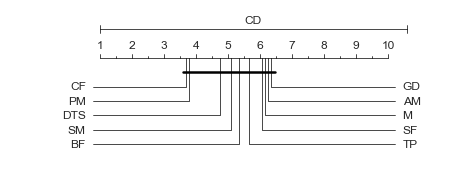

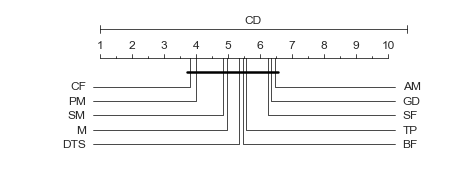

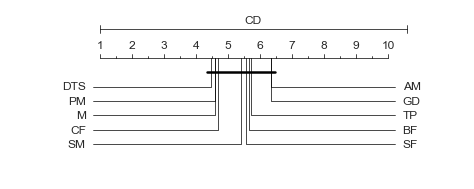

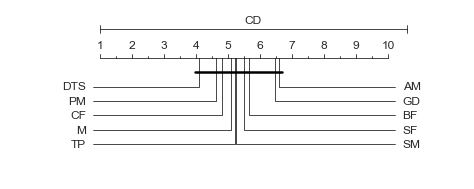

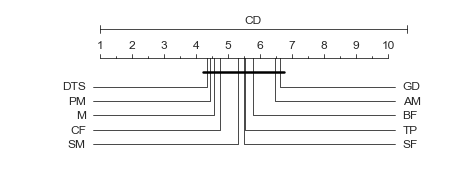

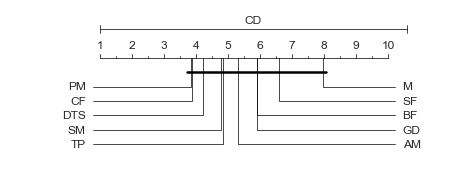

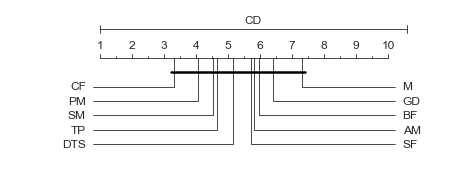

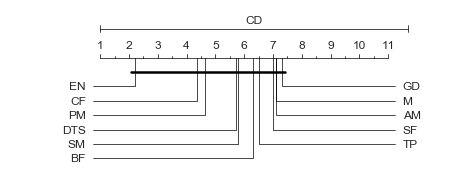

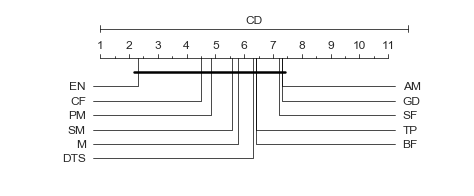

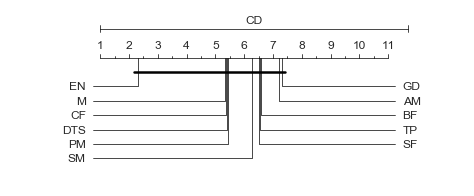

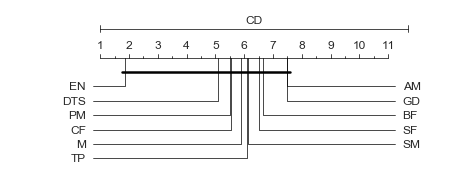

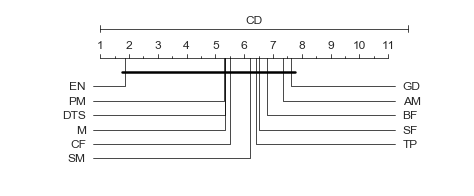

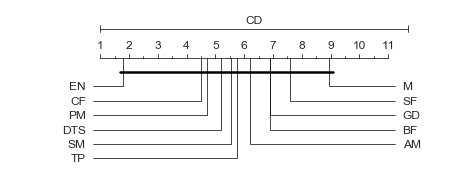

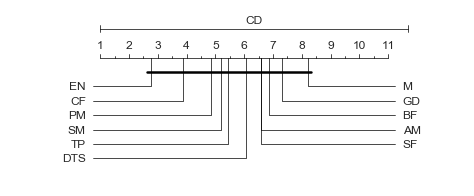

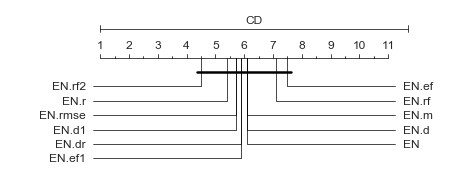

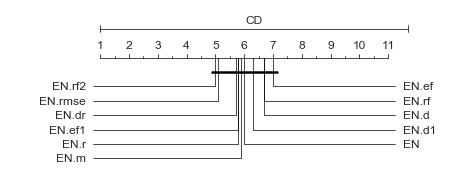

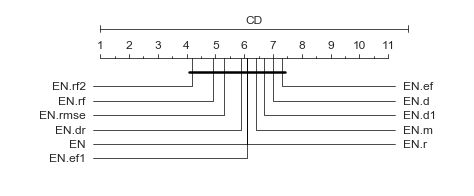

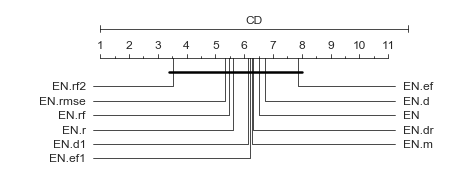

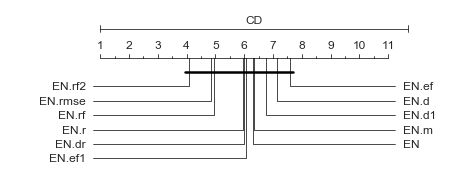

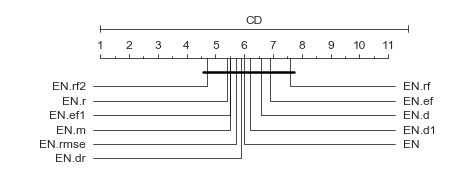

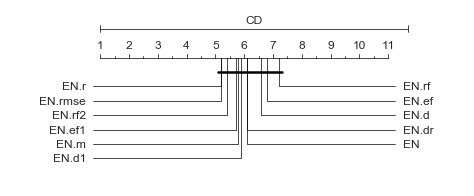

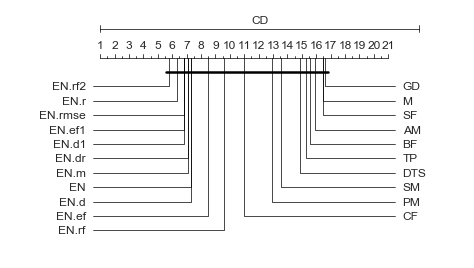

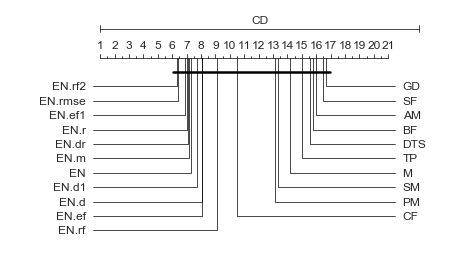

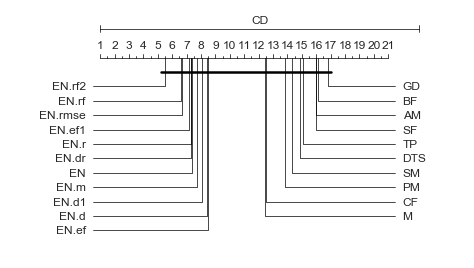

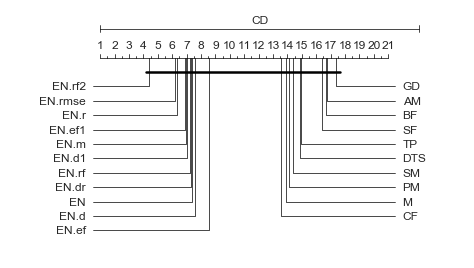

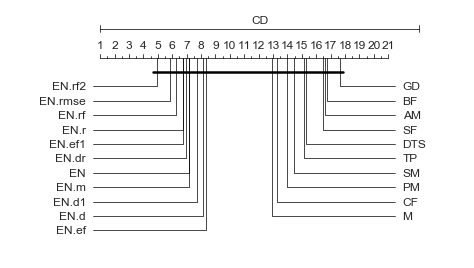

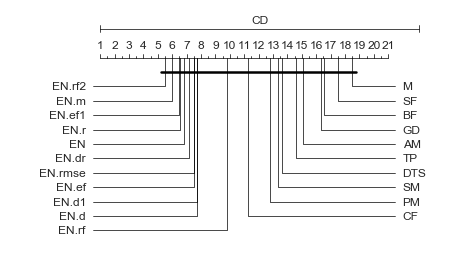

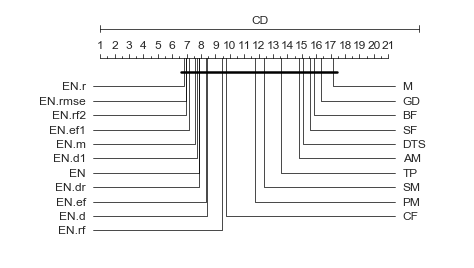

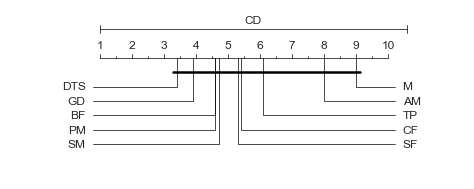

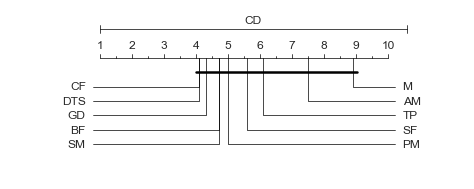

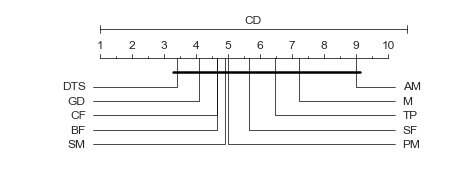

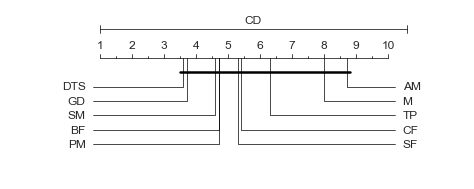

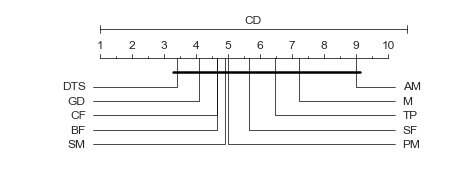

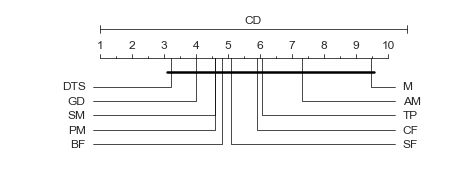

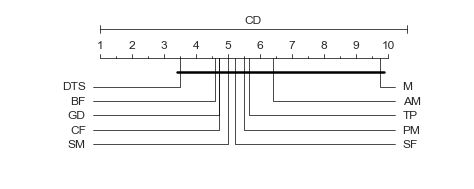

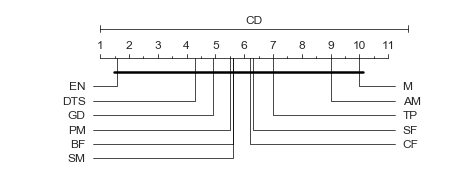

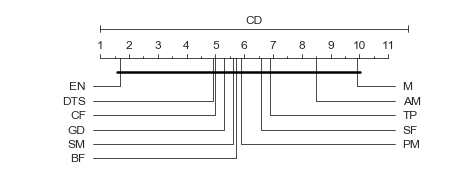

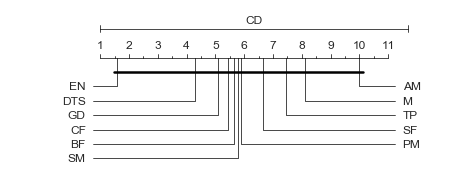

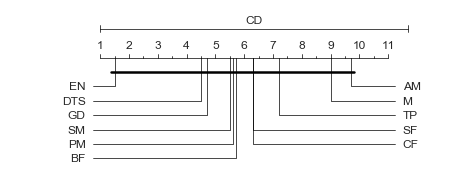

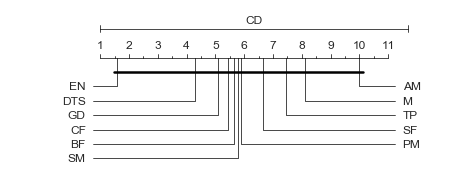

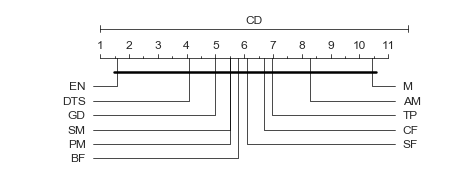

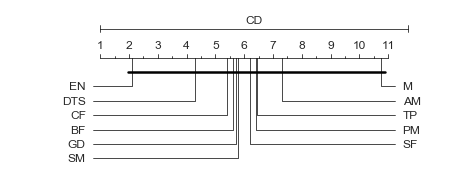

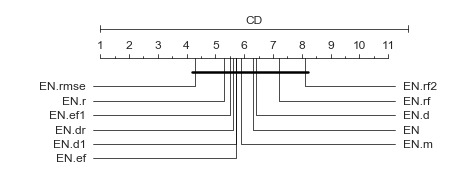

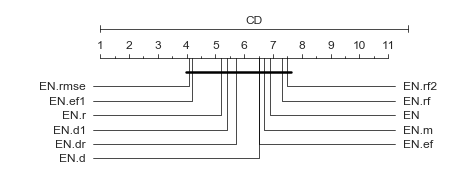

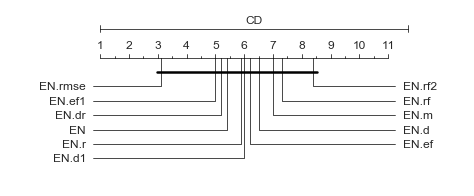

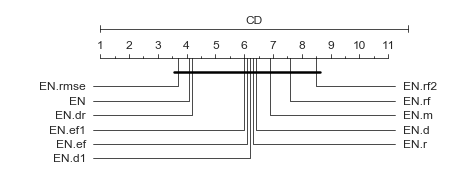

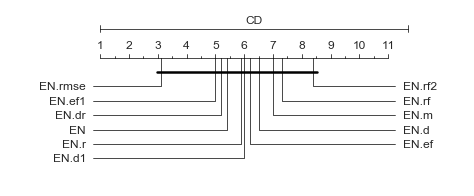

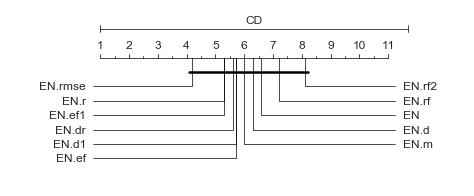

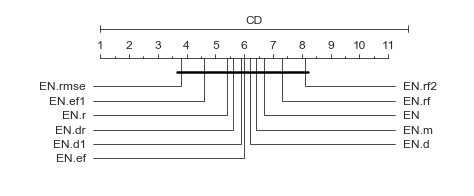

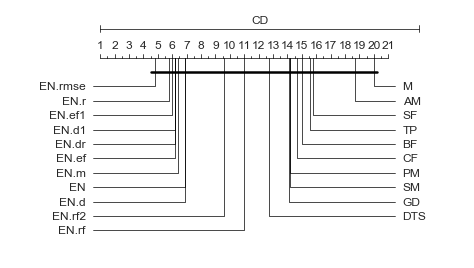

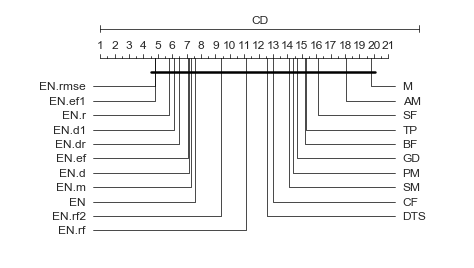

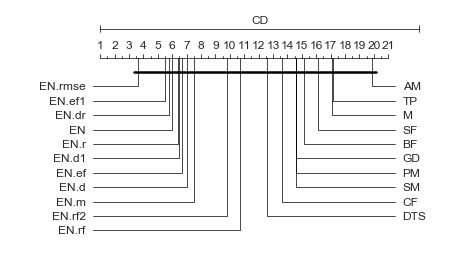

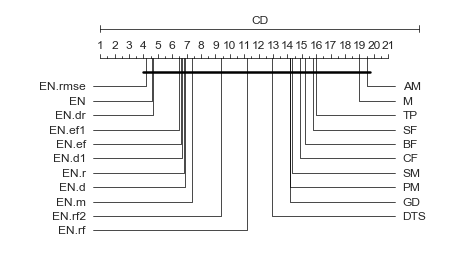

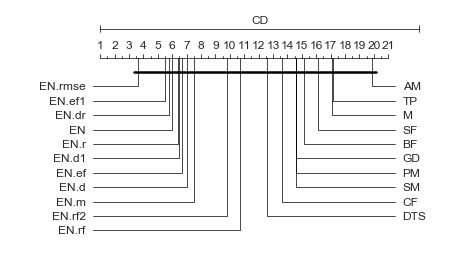

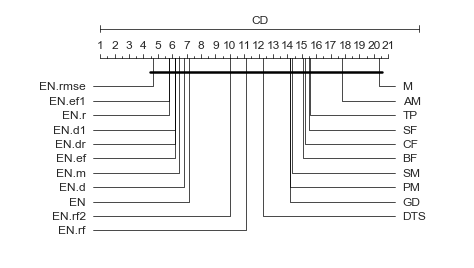

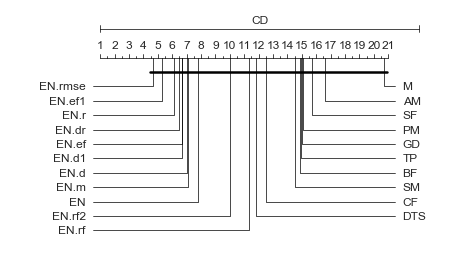

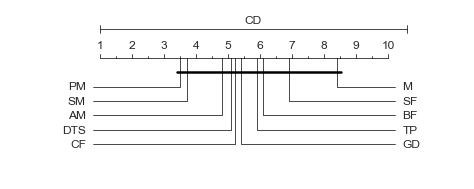

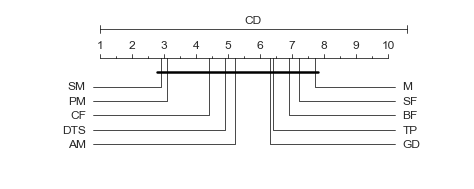

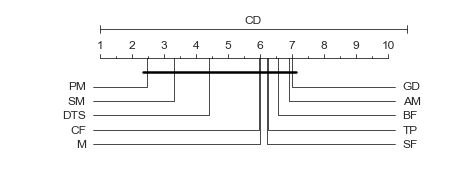

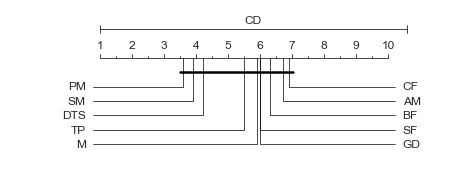

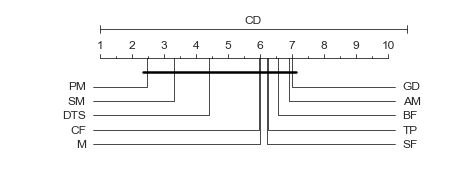

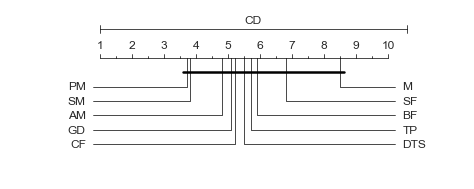

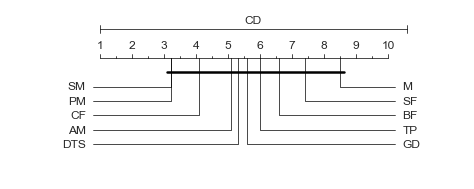

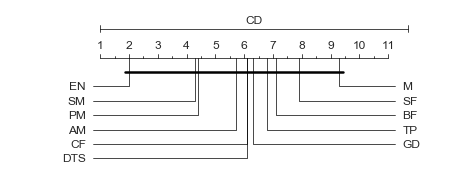

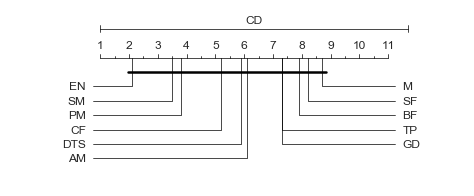

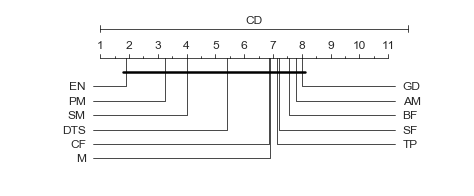

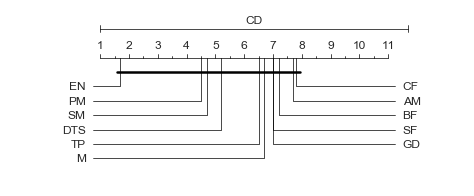

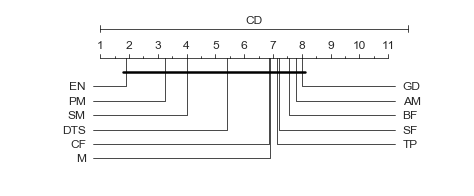

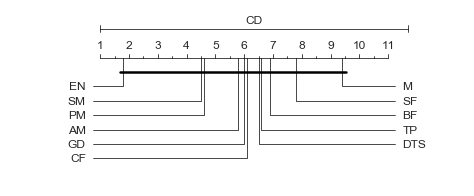

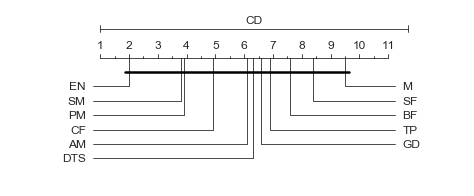

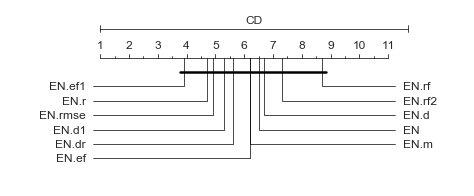

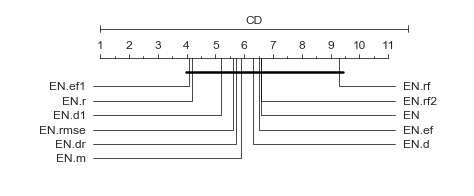

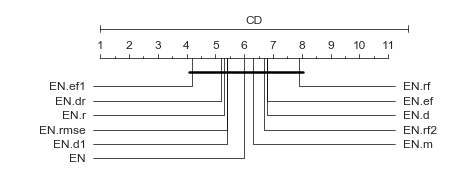

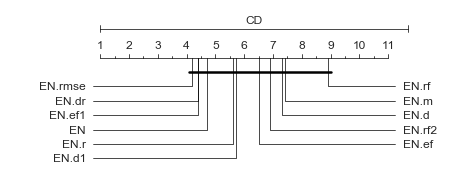

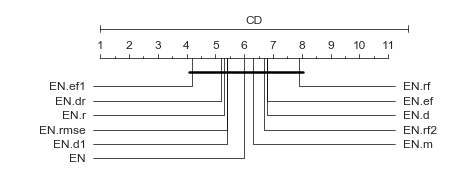

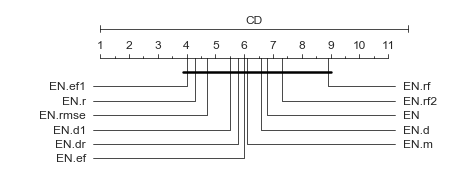

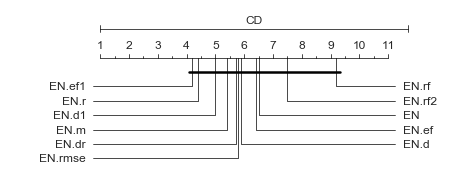

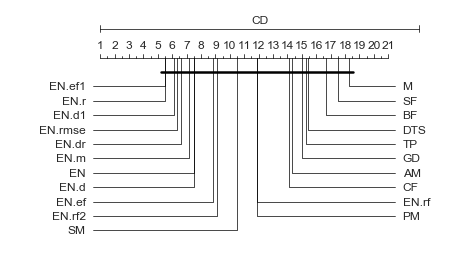

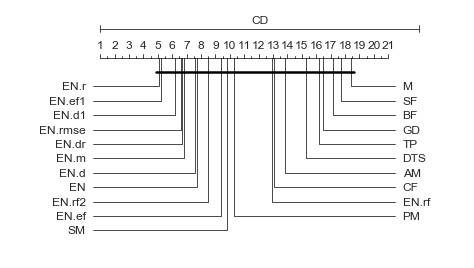

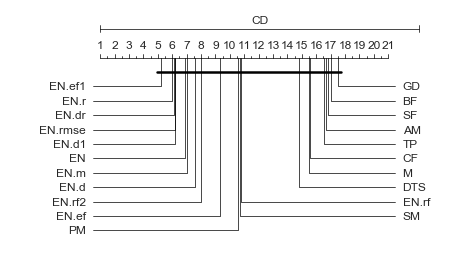

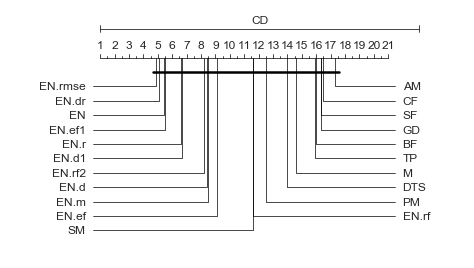

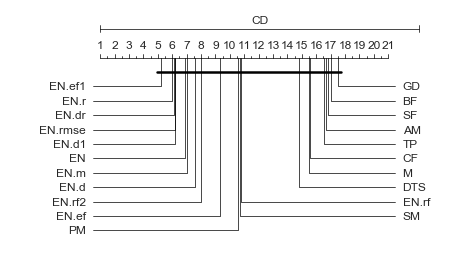

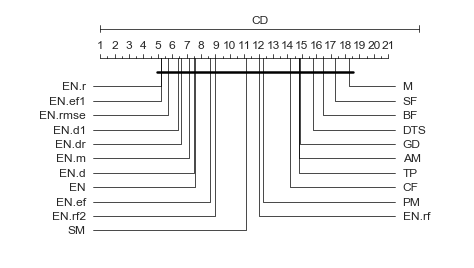

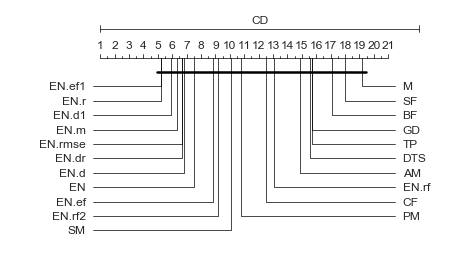

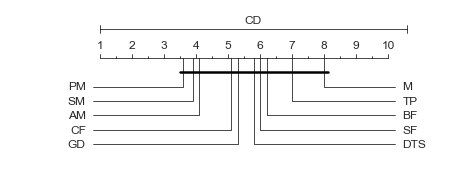

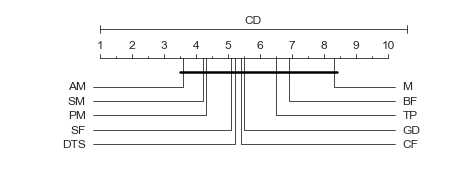

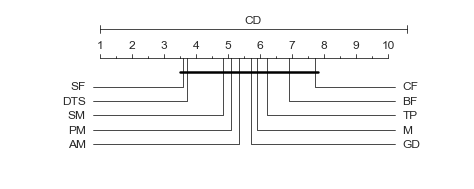

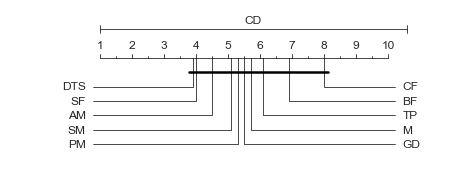

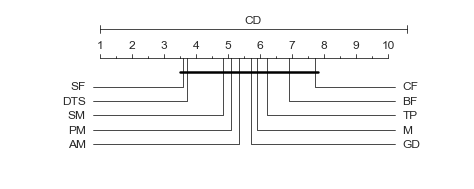

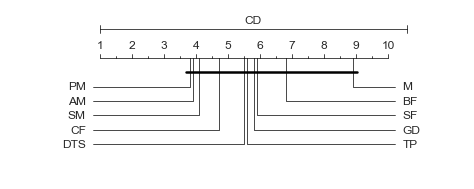

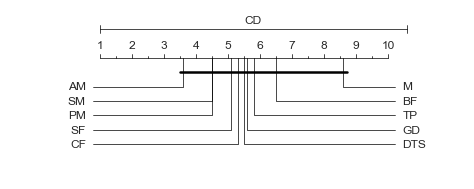

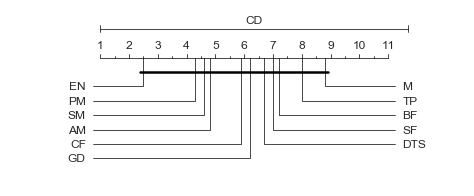

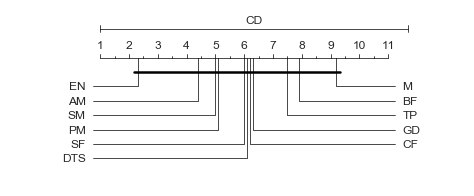

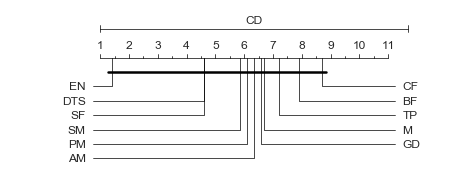

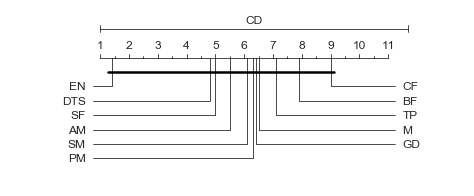

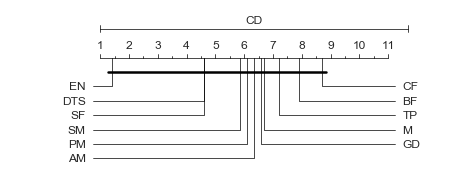

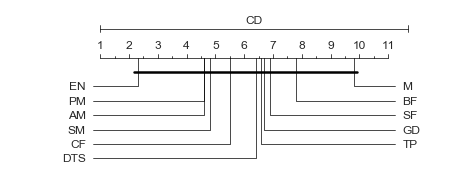

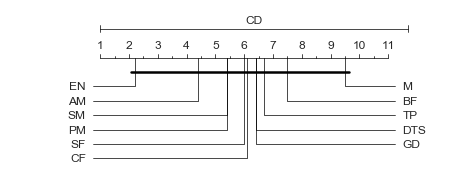

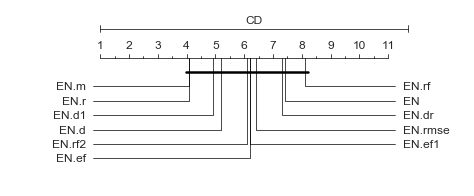

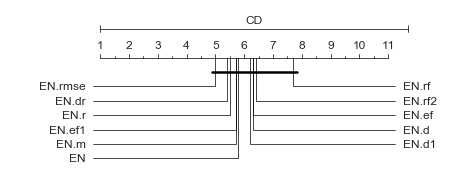

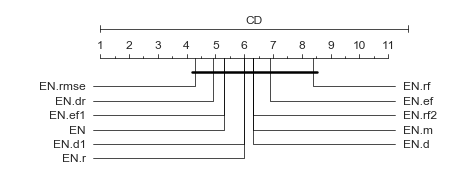

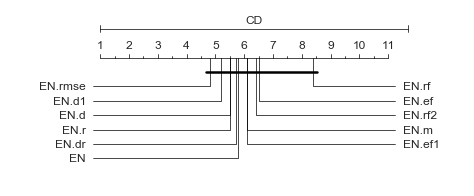

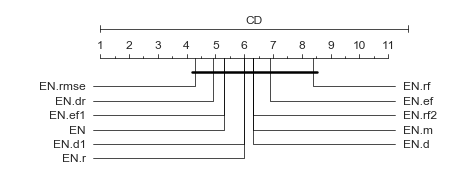

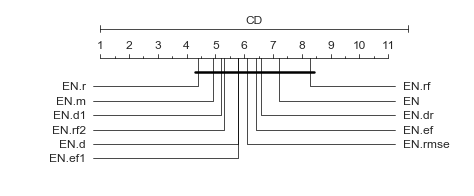

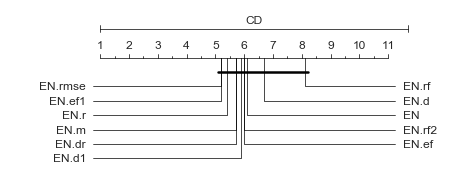

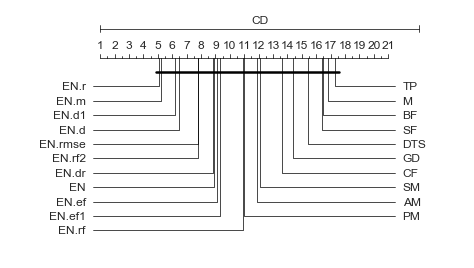

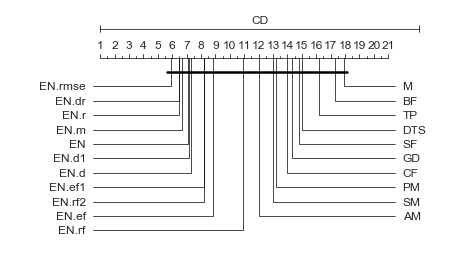

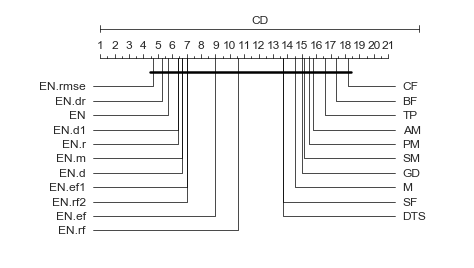

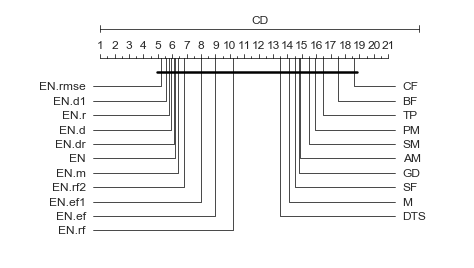

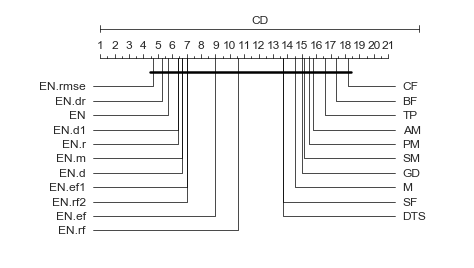

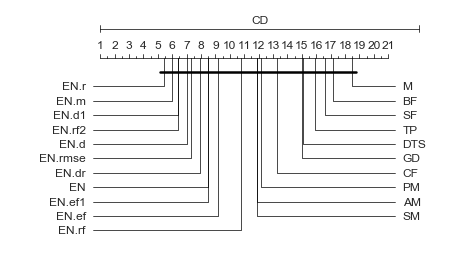

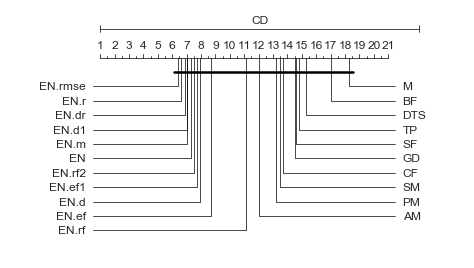

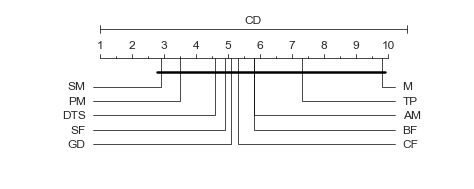

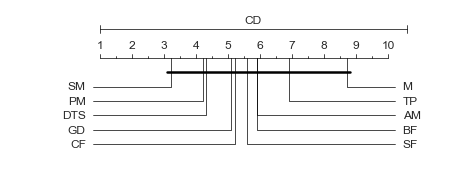

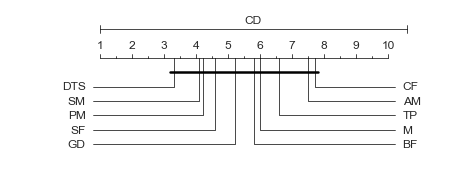

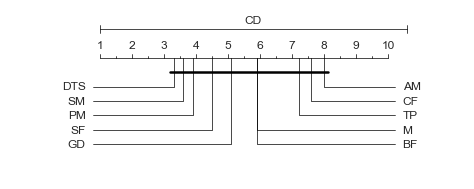

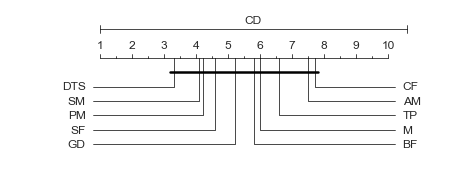

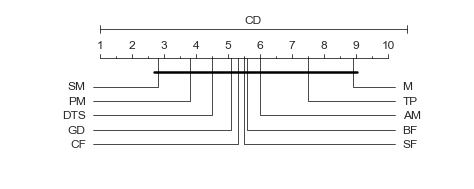

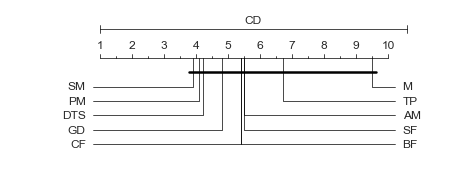

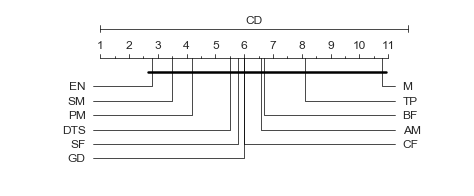

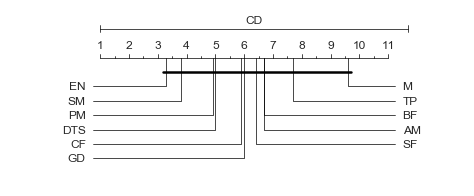

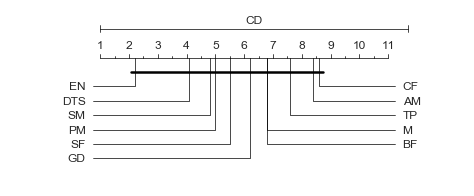

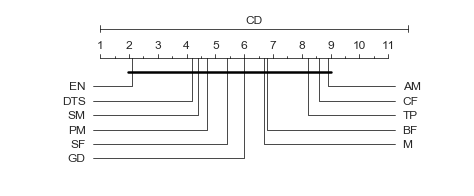

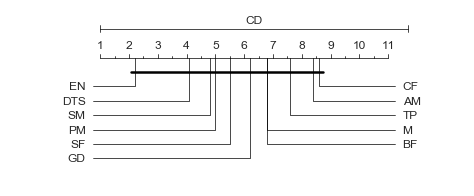

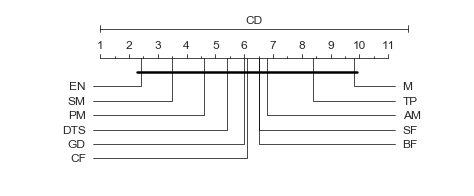

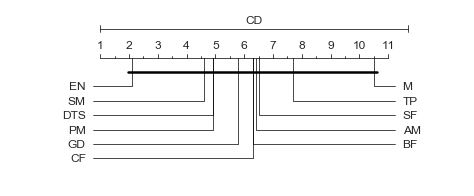

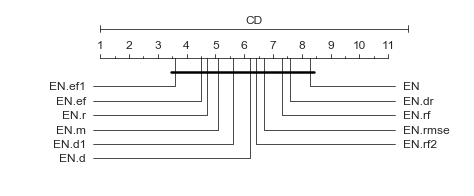

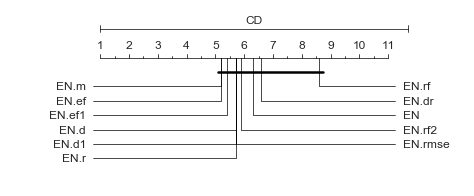

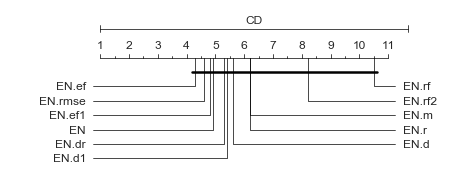

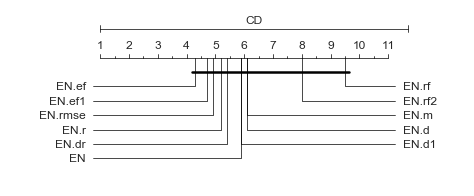

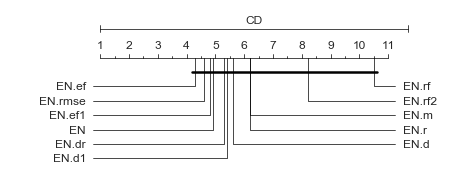

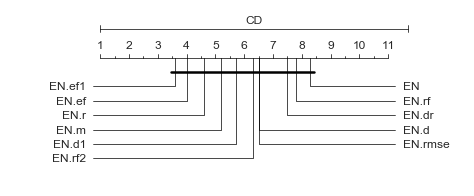

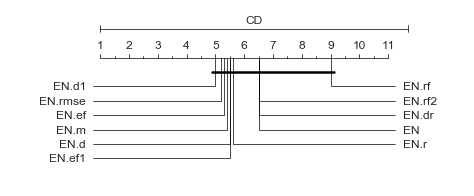

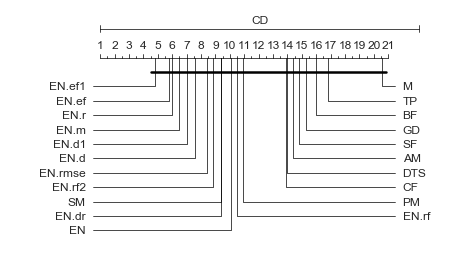

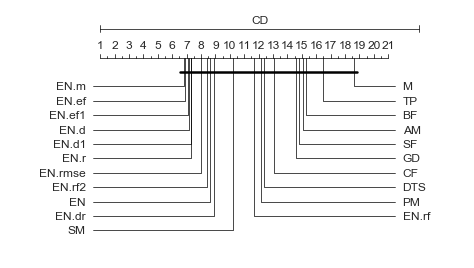

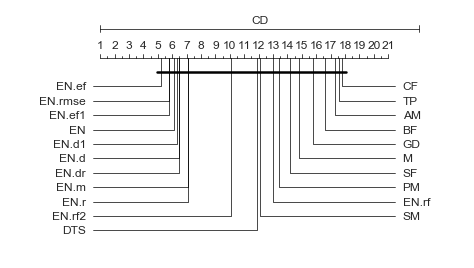

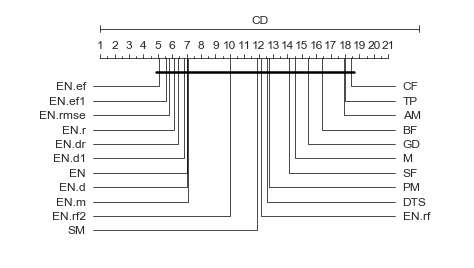

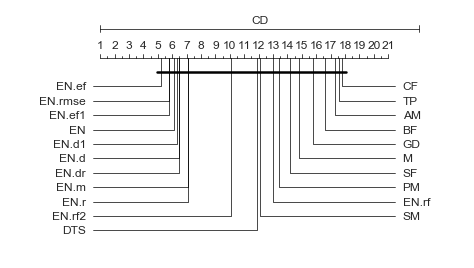

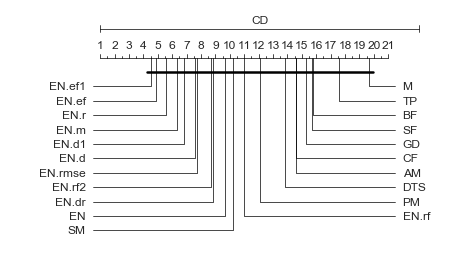

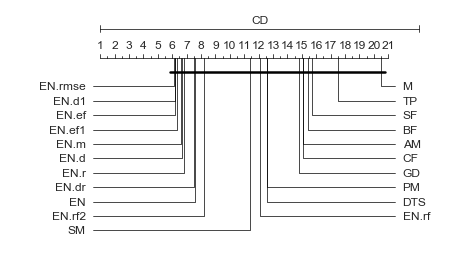

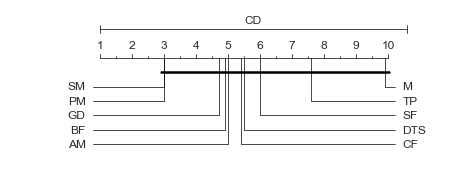

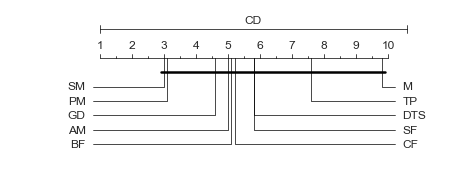

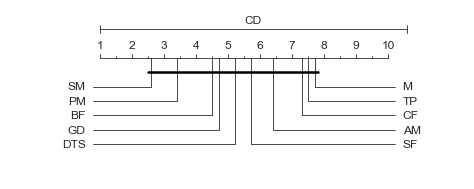

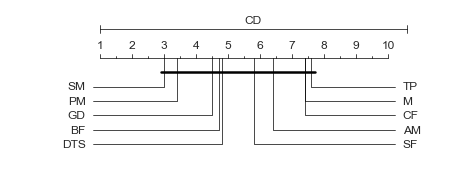

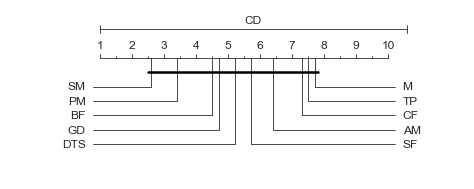

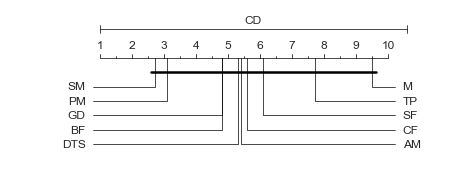

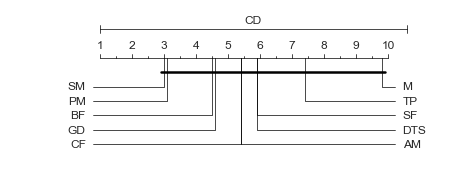

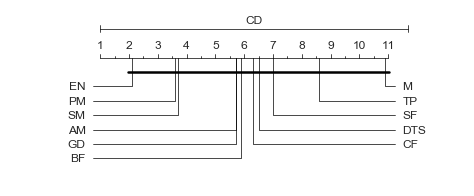

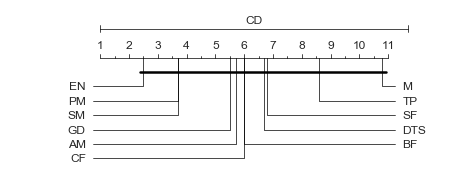

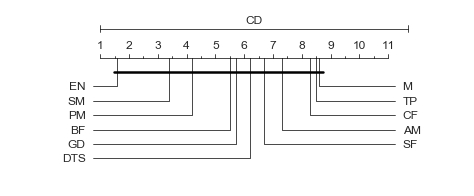

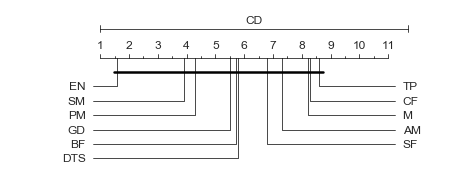

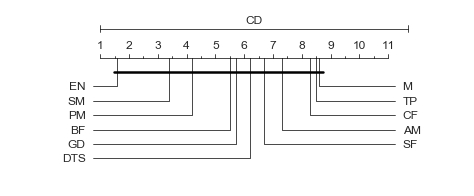

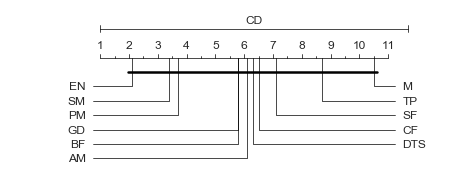

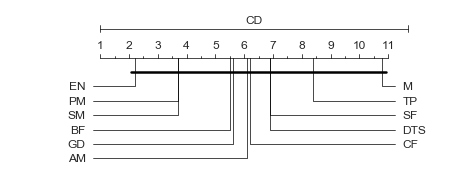

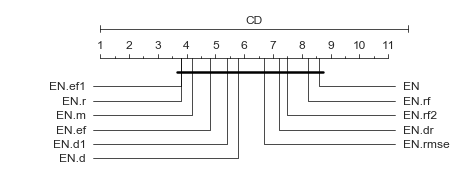

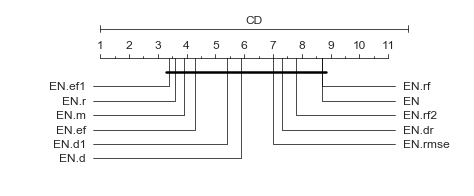

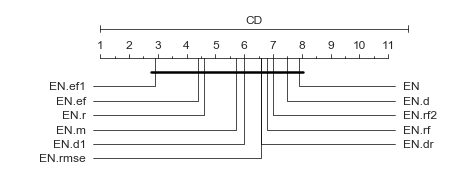

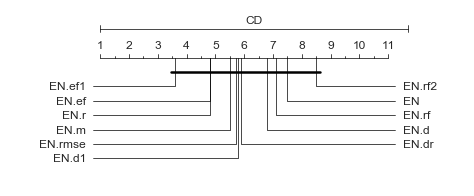

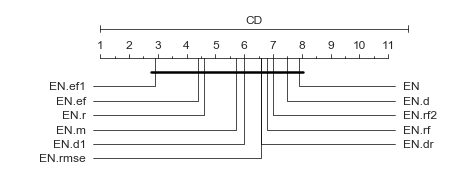

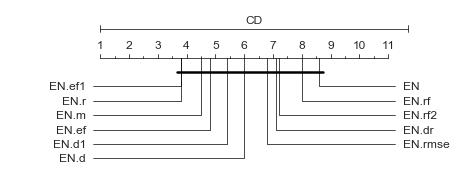

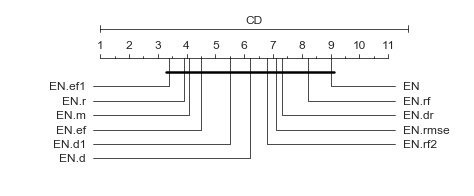

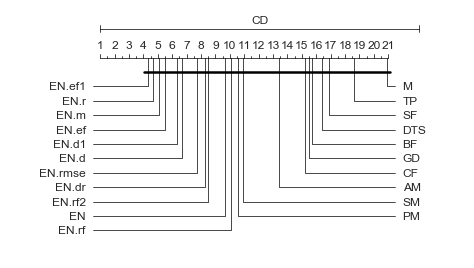

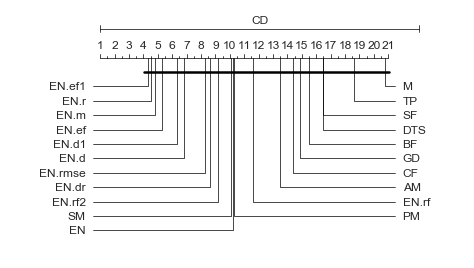

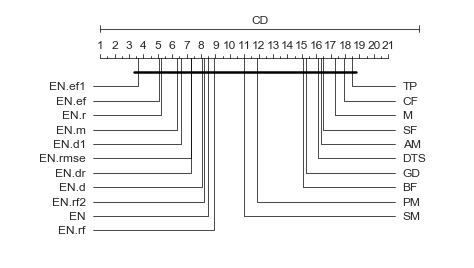

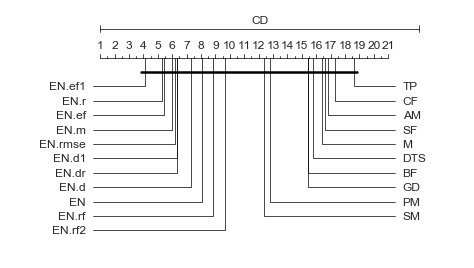

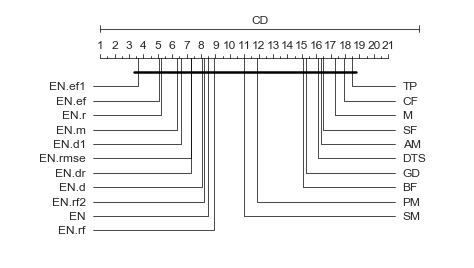

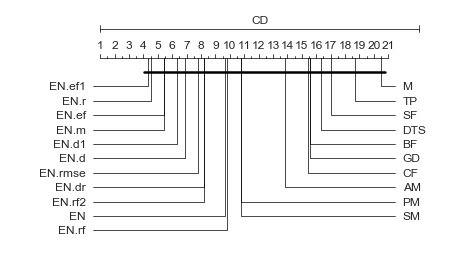

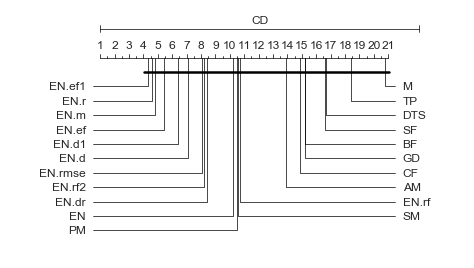

In [65]:
[plot_all_period(p) for p in periods]

Implement Nemenyi test.

In [66]:
def nemenyi(rdf, how, p=0.05, boolean=True):
    df = rdf.loc[how]
    s = df.mean(axis=0)
    C = list(itertools.combinations(s.index, 2))
    cd = critical_difference(p, len(s), len(df))
    if boolean:
        return pd.Series({"{}-{}".format(b, a): abs(s[b] - s[a]) > cd for (a, b) in C})
    else:
        r = pd.Series({"{}-{}".format(b, a): s[b] - s[a] for (a, b) in C})
        r['critical difference'] = cd
        return r

In [67]:
def nemenyis(rdf, p=0.05, boolean=True):
    return pd.DataFrame({h: nemenyi(rdf, h, p, boolean) for h in hows})

In [68]:
nemenyi(rii2[20], 'DR')

AM-BF     False
AM-CF     False
AM-DTS    False
AM-GD     False
AM-PM     False
AM-SF     False
AM-SM     False
AM-TP     False
BF-CF     False
BF-GD     False
CF-GD     False
DTS-BF    False
DTS-CF    False
DTS-GD    False
M-AM      False
M-BF      False
M-CF      False
M-DTS     False
M-GD      False
M-PM      False
M-SF      False
M-SM      False
M-TP      False
PM-BF     False
PM-CF     False
PM-DTS    False
PM-GD     False
PM-SF     False
PM-SM     False
PM-TP     False
SF-BF     False
SF-CF     False
SF-DTS    False
SF-GD     False
SM-BF     False
SM-CF     False
SM-DTS    False
SM-GD     False
SM-SF     False
SM-TP     False
TP-BF     False
TP-CF     False
TP-DTS    False
TP-GD     False
TP-SF     False
dtype: bool

In [69]:
nemenyi(rii2[20], 'DR', boolean=False)

AM-BF                  4.350000
AM-CF                  4.350000
AM-DTS                 5.600000
AM-GD                  4.900000
AM-PM                  4.000000
AM-SF                  3.350000
AM-SM                  4.100000
AM-TP                  2.550000
BF-CF                  0.000000
BF-GD                  0.550000
CF-GD                  0.550000
DTS-BF                -1.250000
DTS-CF                -1.250000
DTS-GD                -0.700000
M-AM                  -1.800000
M-BF                   2.550000
M-CF                   2.550000
M-DTS                  3.800000
M-GD                   3.100000
M-PM                   2.200000
M-SF                   1.550000
M-SM                   2.300000
M-TP                   0.750000
PM-BF                  0.350000
PM-CF                  0.350000
PM-DTS                 1.600000
PM-GD                  0.900000
PM-SF                 -0.650000
PM-SM                  0.100000
PM-TP                 -1.450000
SF-BF                  1.000000
SF-CF   

In [70]:
nemenyis(rii2[20], p=0.05)

,D,D1,DR,EF,EF1,M,R
AM-BF,False,False,False,False,False,False,False
AM-CF,False,False,False,False,False,False,False
AM-DTS,False,False,False,False,False,False,False
AM-GD,False,False,False,False,False,False,False
AM-PM,False,False,False,False,False,False,False
AM-SF,False,False,False,False,False,False,False
AM-SM,False,False,False,False,False,False,False
AM-TP,False,False,False,False,False,False,False
BF-CF,False,False,False,False,False,False,False
BF-GD,False,False,False,False,False,False,False


In [71]:
nemenyis(rii2[20], p=0.05, boolean=False)

,D,D1,DR,EF,EF1,M,R
AM-BF,3.400000,2.800000,4.350000,4.000000e+00,4.350000,2.500000,1.800000
AM-CF,2.600000,3.400000,4.350000,3.300000e+00,4.350000,1.400000,1.700000
AM-DTS,4.600000,3.400000,5.600000,5.100000e+00,5.600000,4.100000,2.900000
AM-GD,4.100000,3.200000,4.900000,5.000000e+00,4.900000,3.300000,1.700000
AM-PM,3.400000,2.500000,4.000000,4.000000e+00,4.000000,2.700000,0.900000
AM-SF,2.700000,1.900000,3.350000,3.400000e+00,3.350000,2.200000,1.200000
AM-SM,3.300000,2.800000,4.100000,4.100000e+00,4.100000,2.700000,1.400000
AM-TP,1.900000,1.400000,2.550000,2.400000e+00,2.550000,1.250000,0.750000
BF-CF,-0.800000,0.600000,0.000000,-7.000000e-01,0.000000,-1.100000,-0.100000
BF-GD,0.700000,0.400000,0.550000,1.000000e+00,0.550000,0.800000,-0.100000


DR metric indicated that DTS was significantly better than Beta. EF metric indicated that DTS was significantly better than CF and Beta. But, no metric could show significant difference between DTS and GD. Also, there was no significance reported by other five metrics at all. All tests were conducted at p=0.05 level.

In [72]:
rii2[20]

GD   CF   BF  DTS   SF   TP   SM   PM   AM    M
how title     period group                                                  
D   cherry_dc 20     0      2.6  6.8  4.8  2.8  5.4  4.8  5.6  5.6  7.8  8.8
                     1      5.2  4.0  4.4  4.0  5.2  7.4  3.8  3.6  8.2  9.2
D1  cherry_dc 20     0      3.6  5.4  5.0  4.0  5.2  4.2  5.4  6.0  7.0  9.2
                     1      5.0  2.8  4.4  4.2  6.0  8.0  4.0  4.0  8.0  8.6
DR  cherry_dc 20     0      3.0  6.1  4.7  3.6  5.3  5.1  5.2  5.4  8.8  7.8
                     1      5.2  3.2  4.6  3.2  6.0  7.8  4.6  4.6  9.2  6.6
EF  cherry_dc 20     0      2.6  6.6  4.8  3.6  4.8  4.8  5.0  5.0  8.4  9.4
                     1      4.8  4.2  4.6  3.6  5.8  7.8  4.2  4.4  9.0  6.6
EF1 cherry_dc 20     0      3.0  6.1  4.7  3.6  5.3  5.1  5.2  5.4  8.8  7.8
                     1      5.2  3.2  4.6  3.2  6.0  7.8  4.6  4.6  9.2  6.6
M   cherry_dc 20     0      2.8  7.6  5.2  2.4  5.2  4.6  5.6  5.6  7.0  9.0
                     1      5.2  4.2  4.4  4.0  5.0  7.5  3.6  3.6  7.6  9.9
R   cherry_dc 20     0      4.2  5.8  5.0  3.2  5.4  3.6  5.8  6.8  5.6  9.6
                     1      5.2  3.6  4.2  3.8  5.0  7.7  4.2  4.2  7.2  9.9

In [73]:
nemenyis(rii2[20], p=0.10)

,D,D1,DR,EF,EF1,M,R
AM-BF,False,False,False,False,False,False,False
AM-CF,False,False,False,False,False,False,False
AM-DTS,False,False,False,False,False,False,False
AM-GD,False,False,False,False,False,False,False
AM-PM,False,False,False,False,False,False,False
AM-SF,False,False,False,False,False,False,False
AM-SM,False,False,False,False,False,False,False
AM-TP,False,False,False,False,False,False,False
BF-CF,False,False,False,False,False,False,False
BF-GD,False,False,False,False,False,False,False


In [74]:
nemenyis(rii2[20], p=0.10, boolean=False)

,D,D1,DR,EF,EF1,M,R
AM-BF,3.400000,2.800000,4.350000,4.000000e+00,4.350000,2.500000,1.800000
AM-CF,2.600000,3.400000,4.350000,3.300000e+00,4.350000,1.400000,1.700000
AM-DTS,4.600000,3.400000,5.600000,5.100000e+00,5.600000,4.100000,2.900000
AM-GD,4.100000,3.200000,4.900000,5.000000e+00,4.900000,3.300000,1.700000
AM-PM,3.400000,2.500000,4.000000,4.000000e+00,4.000000,2.700000,0.900000
AM-SF,2.700000,1.900000,3.350000,3.400000e+00,3.350000,2.200000,1.200000
AM-SM,3.300000,2.800000,4.100000,4.100000e+00,4.100000,2.700000,1.400000
AM-TP,1.900000,1.400000,2.550000,2.400000e+00,2.550000,1.250000,0.750000
BF-CF,-0.800000,0.600000,0.000000,-7.000000e-01,0.000000,-1.100000,-0.100000
BF-GD,0.700000,0.400000,0.550000,1.000000e+00,0.550000,0.800000,-0.100000


The ensemble model (EN) was significantly better than Beta and GD in all metrics. Three metrics, DR, EF, and EF1, reported significant difference against CF. Two metrics, D and M, reported significant difference against DTS. (p=0.05).

In [75]:
nemenyis(rie2[20], p=0.05)

,D,D1,DR,EF,EF1,M,R
AM-BF,False,False,False,False,False,False,False
AM-CF,False,False,False,False,False,False,False
AM-DTS,False,False,False,False,False,False,False
AM-GD,False,False,False,False,False,False,False
AM-PM,False,False,False,False,False,False,False
AM-SF,False,False,False,False,False,False,False
AM-SM,False,False,False,False,False,False,False
AM-TP,False,False,False,False,False,False,False
BF-CF,False,False,False,False,False,False,False
BF-GD,False,False,False,False,False,False,False


In [76]:
nemenyis(rie2[20], p=0.05, boolean=False)

,D,D1,DR,EF,EF1,M,R
AM-BF,3.400000,2.800000,4.350000,4.000000,4.350000,2.500000,1.700000
AM-CF,2.800000,3.500000,4.550000,3.400000,4.550000,1.600000,1.900000
AM-DTS,4.700000,3.600000,5.700000,5.200000,5.700000,4.200000,3.000000
AM-GD,4.100000,3.200000,4.900000,5.000000,4.900000,3.300000,1.600000
AM-PM,3.500000,2.600000,4.100000,4.100000,4.100000,2.800000,0.900000
AM-SF,2.700000,1.900000,3.350000,3.400000,3.350000,2.200000,1.100000
AM-SM,3.400000,2.900000,4.200000,4.200000,4.200000,2.800000,1.500000
AM-TP,2.000000,1.600000,2.550000,2.500000,2.550000,1.350000,0.850000
BF-CF,-0.600000,0.700000,0.200000,-0.600000,0.200000,-0.900000,0.200000
BF-GD,0.700000,0.400000,0.550000,1.000000,0.550000,0.800000,-0.100000


In [77]:
nemenyis(rie2[20], p=0.10)

,D,D1,DR,EF,EF1,M,R
AM-BF,False,False,False,False,False,False,False
AM-CF,False,False,False,False,False,False,False
AM-DTS,False,False,False,False,False,False,False
AM-GD,False,False,False,False,False,False,False
AM-PM,False,False,False,False,False,False,False
AM-SF,False,False,False,False,False,False,False
AM-SM,False,False,False,False,False,False,False
AM-TP,False,False,False,False,False,False,False
BF-CF,False,False,False,False,False,False,False
BF-GD,False,False,False,False,False,False,False


In [78]:
nemenyis(rie2[20], p=0.10, boolean=False)

,D,D1,DR,EF,EF1,M,R
AM-BF,3.40000,2.80000,4.35000,4.00000,4.35000,2.50000,1.70000
AM-CF,2.80000,3.50000,4.55000,3.40000,4.55000,1.60000,1.90000
AM-DTS,4.70000,3.60000,5.70000,5.20000,5.70000,4.20000,3.00000
AM-GD,4.10000,3.20000,4.90000,5.00000,4.90000,3.30000,1.60000
AM-PM,3.50000,2.60000,4.10000,4.10000,4.10000,2.80000,0.90000
AM-SF,2.70000,1.90000,3.35000,3.40000,3.35000,2.20000,1.10000
AM-SM,3.40000,2.90000,4.20000,4.20000,4.20000,2.80000,1.50000
AM-TP,2.00000,1.60000,2.55000,2.50000,2.55000,1.35000,0.85000
BF-CF,-0.60000,0.70000,0.20000,-0.60000,0.20000,-0.90000,0.20000
BF-GD,0.70000,0.40000,0.55000,1.00000,0.55000,0.80000,-0.10000


There was no single incidence reported by all metrics that any ensemble model significantly outperformed (at p=0.05).

In [79]:
nemenyis(ree2[20], p=0.05)

,D,D1,DR,EF,EF1,M,R
EN.d-EN,False,False,False,False,False,False,False
EN.d-EN.rmse,False,False,False,False,False,False,False
EN.d1-EN,False,False,False,False,False,False,False
EN.d1-EN.d,False,False,False,False,False,False,False
EN.d1-EN.rmse,False,False,False,False,False,False,False
EN.dr-EN,False,False,False,False,False,False,False
EN.dr-EN.d,False,False,False,False,False,False,False
EN.dr-EN.d1,False,False,False,False,False,False,False
EN.dr-EN.rmse,False,False,False,False,False,False,False
EN.ef-EN,False,False,False,False,False,False,False


In [80]:
nemenyis(ree2[20], p=0.05, boolean=False)

,D,D1,DR,EF,EF1,M,R
EN.d-EN,1.000000e-01,-0.400000,1.100000,2.300000,1.100000,-3.000000e-01,-0.500000
EN.d-EN.rmse,2.100000e+00,2.400000,3.400000,2.700000,3.400000,2.100000e+00,2.400000
EN.d1-EN,-6.000000e-01,-1.500000,0.600000,2.100000,0.600000,-9.000000e-01,-0.800000
EN.d1-EN.d,-7.000000e-01,-1.100000,-0.500000,-0.200000,-0.500000,-6.000000e-01,-0.300000
EN.d1-EN.rmse,1.400000e+00,1.300000,2.900000,2.500000,2.900000,1.500000e+00,2.100000
EN.dr-EN,-7.000000e-01,-1.200000,-0.200000,0.100000,-0.200000,-1.000000e+00,-1.100000
EN.dr-EN.d,-8.000000e-01,-0.800000,-1.300000,-2.200000,-1.300000,-7.000000e-01,-0.600000
EN.dr-EN.d1,-1.000000e-01,0.300000,-0.800000,-2.000000,-0.800000,-1.000000e-01,-0.300000
EN.dr-EN.rmse,1.300000e+00,1.600000,2.100000,0.500000,2.100000,1.400000e+00,1.800000
EN.ef-EN,-6.000000e-01,-0.400000,0.800000,2.000000,0.800000,-9.000000e-01,-0.700000


In [81]:
nemenyis(ree2[20], p=0.10)

,D,D1,DR,EF,EF1,M,R
EN.d-EN,False,False,False,False,False,False,False
EN.d-EN.rmse,False,False,False,False,False,False,False
EN.d1-EN,False,False,False,False,False,False,False
EN.d1-EN.d,False,False,False,False,False,False,False
EN.d1-EN.rmse,False,False,False,False,False,False,False
EN.dr-EN,False,False,False,False,False,False,False
EN.dr-EN.d,False,False,False,False,False,False,False
EN.dr-EN.d1,False,False,False,False,False,False,False
EN.dr-EN.rmse,False,False,False,False,False,False,False
EN.ef-EN,False,False,False,False,False,False,False


In [82]:
nemenyis(ree2[20], p=0.10, boolean=False)

,D,D1,DR,EF,EF1,M,R
EN.d-EN,1.000000e-01,-0.40000,1.10000,2.30000,1.10000,-3.000000e-01,-0.50000
EN.d-EN.rmse,2.100000e+00,2.40000,3.40000,2.70000,3.40000,2.100000e+00,2.40000
EN.d1-EN,-6.000000e-01,-1.50000,0.60000,2.10000,0.60000,-9.000000e-01,-0.80000
EN.d1-EN.d,-7.000000e-01,-1.10000,-0.50000,-0.20000,-0.50000,-6.000000e-01,-0.30000
EN.d1-EN.rmse,1.400000e+00,1.30000,2.90000,2.50000,2.90000,1.500000e+00,2.10000
EN.dr-EN,-7.000000e-01,-1.20000,-0.20000,0.10000,-0.20000,-1.000000e+00,-1.10000
EN.dr-EN.d,-8.000000e-01,-0.80000,-1.30000,-2.20000,-1.30000,-7.000000e-01,-0.60000
EN.dr-EN.d1,-1.000000e-01,0.30000,-0.80000,-2.00000,-0.80000,-1.000000e-01,-0.30000
EN.dr-EN.rmse,1.300000e+00,1.60000,2.10000,0.50000,2.10000,1.400000e+00,1.80000
EN.ef-EN,-6.000000e-01,-0.40000,0.80000,2.00000,0.80000,-9.000000e-01,-0.70000


Test each dataset separately.

In [83]:
def extract(rdf, title):
    return rdf.xs(title, level='title')

In [84]:
def friedman2(rdf, how):
    titles = rdf.index.get_level_values('title').unique()
    return {t: friedman(extract(rdf, t), how) for t in titles}

In [85]:
pd.DataFrame({h: friedman2(rii2[20], h) for h in hows})

,D,D1,DR,EF,EF1,M,R
cherry_dc,"(10.9325153374, 0.280363062476)","(10.2385321101, 0.331522182671)","(12.1569230769, 0.204606632217)","(11.4166666667, 0.248225714903)","(12.1569230769, 0.204606632217)","(10.7064220183, 0.296370162214)","(9.66461538462, 0.378312318353)"


#### DC Cherry

In [86]:
friedmans(extract(rii2[20], 'cherry_dc'))

,D,D1,DR,EF,EF1,M,R
statistic,10.932515,10.238532,12.156923,11.416667,12.156923,10.706422,9.664615
pvalue,0.280363,0.331522,0.204607,0.248226,0.204607,0.296370,0.378312


In [87]:
nemenyis(extract(rii2[20], 'cherry_dc'))

,D,D1,DR,EF,EF1,M,R
AM-BF,False,False,False,False,False,False,False
AM-CF,False,False,False,False,False,False,False
AM-DTS,False,False,False,False,False,False,False
AM-GD,False,False,False,False,False,False,False
AM-PM,False,False,False,False,False,False,False
AM-SF,False,False,False,False,False,False,False
AM-SM,False,False,False,False,False,False,False
AM-TP,False,False,False,False,False,False,False
BF-CF,False,False,False,False,False,False,False
BF-GD,False,False,False,False,False,False,False


In [88]:
friedmans(extract(rie2[20], 'cherry_dc'))

,D,D1,DR,EF,EF1,M,R
statistic,13.638444,13.348624,14.555809,14.233410,14.555809,13.577982,12.465753
pvalue,0.190131,0.204828,0.149115,0.162609,0.149115,0.193126,0.255093


In [89]:
nemenyis(extract(rie2[20], 'cherry_dc'), p=0.05)

,D,D1,DR,EF,EF1,M,R
AM-BF,False,False,False,False,False,False,False
AM-CF,False,False,False,False,False,False,False
AM-DTS,False,False,False,False,False,False,False
AM-GD,False,False,False,False,False,False,False
AM-PM,False,False,False,False,False,False,False
AM-SF,False,False,False,False,False,False,False
AM-SM,False,False,False,False,False,False,False
AM-TP,False,False,False,False,False,False,False
BF-CF,False,False,False,False,False,False,False
BF-GD,False,False,False,False,False,False,False


In [90]:
nemenyis(extract(rie2[20], 'cherry_dc'), p=0.10)

,D,D1,DR,EF,EF1,M,R
AM-BF,False,False,False,False,False,False,False
AM-CF,False,False,False,False,False,False,False
AM-DTS,False,False,False,False,False,False,False
AM-GD,False,False,False,False,False,False,False
AM-PM,False,False,False,False,False,False,False
AM-SF,False,False,False,False,False,False,False
AM-SM,False,False,False,False,False,False,False
AM-TP,False,False,False,False,False,False,False
BF-CF,False,False,False,False,False,False,False
BF-GD,False,False,False,False,False,False,False


In [91]:
friedmans(extract(ree2[20], 'cherry_dc'))

,D,D1,DR,EF,EF1,M,R
statistic,8.672769,15.160550,13.789954,15.707763,13.789954,8.922018,13.940092
pvalue,0.563415,0.126317,0.182790,0.108309,0.182790,0.539520,0.175742


In [92]:
nemenyis(extract(ree2[20], 'cherry_dc'), p=0.05)

,D,D1,DR,EF,EF1,M,R
EN.d-EN,False,False,False,False,False,False,False
EN.d-EN.rmse,False,False,False,False,False,False,False
EN.d1-EN,False,False,False,False,False,False,False
EN.d1-EN.d,False,False,False,False,False,False,False
EN.d1-EN.rmse,False,False,False,False,False,False,False
EN.dr-EN,False,False,False,False,False,False,False
EN.dr-EN.d,False,False,False,False,False,False,False
EN.dr-EN.d1,False,False,False,False,False,False,False
EN.dr-EN.rmse,False,False,False,False,False,False,False
EN.ef-EN,False,False,False,False,False,False,False


In [93]:
nemenyis(extract(ree2[20], 'cherry_dc'), p=0.10)

,D,D1,DR,EF,EF1,M,R
EN.d-EN,False,False,False,False,False,False,False
EN.d-EN.rmse,False,False,False,False,False,False,False
EN.d1-EN,False,False,False,False,False,False,False
EN.d1-EN.d,False,False,False,False,False,False,False
EN.d1-EN.rmse,False,False,False,False,False,False,False
EN.dr-EN,False,False,False,False,False,False,False
EN.dr-EN.d,False,False,False,False,False,False,False
EN.dr-EN.d1,False,False,False,False,False,False,False
EN.dr-EN.rmse,False,False,False,False,False,False,False
EN.ef-EN,False,False,False,False,False,False,False


### RMSE

In [94]:
def mean2(df):
    return df.groupby(level=[0,1,2,3]).mean()

In [95]:
def plot_rmse2(df, **kwargs):
    mdf = pd.melt(df.reset_index(), id_vars=['how', 'title', 'period', 'group'], var_name='Model', value_name='rmse')
    ax = sns.boxplot(x='period', y='rmse', hue='Model', data=mdf, palette='Set3', width=0.5, fliersize=2, linewidth=0.5, **kwargs)
    ax.set(xlabel='Period (years)', ylabel='RMSE (day)')
    return ax

In [96]:
def plot_rmse3(df, **kwargs):
    mdf = pd.melt(df.reset_index(), id_vars=['how', 'title', 'period', 'seq'], var_name='Model', value_name='rmse')
    ax = sns.boxplot(x='period', y='rmse', hue='Model', data=mdf, palette='Set3', width=0.5, fliersize=2, linewidth=0.5, **kwargs)
    ax.set(xlabel='Period (years)', ylabel='RMSE (day)')
    return ax

In [97]:
rmseii2 = pd.concat([mean2(load2(individuals, p, metrics=['rmse'])) for p in periods])
rmseie2 = pd.concat([mean2(load2(individuals_with_ensemble, p, metrics=['rmse'])) for p in periods])
rmseee2 = pd.concat([mean2(load2(ensembles, p, metrics=['rmse'])) for p in periods])

In [98]:
rmseie2

GD        CF        BF       DTS        SF  \
how  title     period group                                                     
RMSE cherry_dc 10     0      3.596756  1.631320  3.495189  3.327053  3.874301   
                      1      6.086839  4.629972  4.486067  4.081192  2.454582   
               20     0      3.171248  4.599365  3.549691  3.253400  3.581013   
                      1      4.199107  2.290482  4.116504  2.821656  4.005995   
               30     0      7.167725  8.032805  7.929092  7.034080  7.712871   
                      1      5.617371  5.150518  5.680313  5.221076  4.966032   
               40     0      6.767778  8.862156  7.448276  6.841311  6.982179   
                      1      5.537377  6.192275  5.826102  3.737523  4.235973   
               50     0      6.786369  8.381957  7.373662  6.900789  6.845436   
                      1      5.034465  5.929870  4.926238  3.310036  4.516103   
               60     0      6.707040  7.194668  6.739767  7.132668  6.974088   
                      1      4.164186  6.580511  4.218258  4.016843  4.441710   

                                   TP        SM        PM         AM  \
how  title     period group                                            
RMSE cherry_dc 10     0      6.172081  2.835993  2.737315   5.608629   
                      1      1.906738  4.116718  3.263168   5.827070   
               20     0      3.552846  4.269415  3.975811   9.148814   
                      1      5.768867  3.536164  3.603376   6.392227   
               30     0      6.805566  7.423398  7.323432  10.397091   
                      1      7.644488  3.226411  3.400084   5.206489   
               40     0      7.170935  8.151671  8.338314   9.019769   
                      1      5.745573  3.933352  3.806560   4.045602   
               50     0      7.783072  6.658719  6.844019   8.524161   
                      1      5.776701  3.829435  3.780254   5.504533   
               60     0      7.319097  6.482672  6.738041   7.150355   
                      1      6.013340  3.294667  3.308897   5.487583   

                                    M        EN  
how  title     period group                      
RMSE cherry_dc 10     0      2.812452  1.196528  
                      1      2.931199  1.046136  
               20     0      6.423511  2.279680  
                      1      5.119716  1.480285  
               30     0      6.882427  5.200819  
                      1      5.426074  2.365449  
               40     0      6.753853  5.442016  
                      1      5.693823  3.018306  
               50     0      6.921090  5.654011  
                      1      5.901805  2.932710  
               60     0      7.298669  5.399842  
                      1      6.015315  2.899642

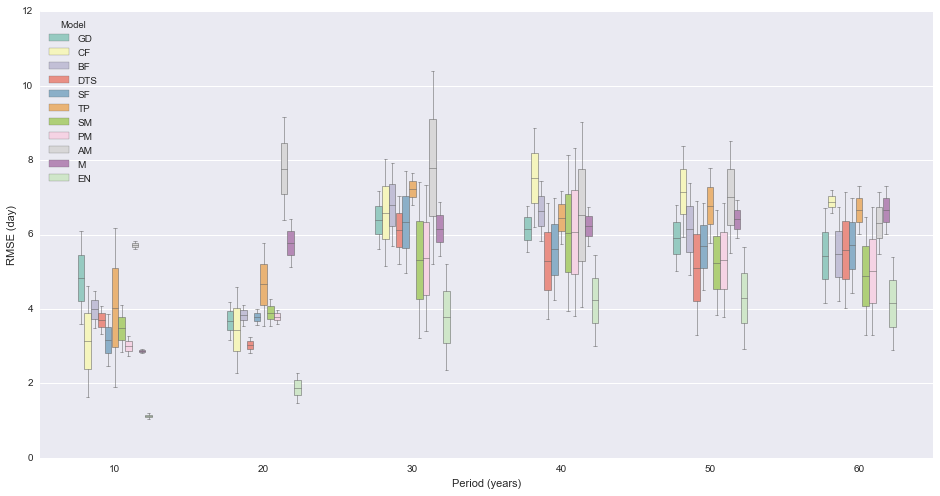

In [101]:
plt.figure(figsize=(16,8))
plot_rmse2(rmseie2)
plt.savefig('rmseie2.png', dpi=600)